## 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

## 데이터 불러오기

In [2]:
data = pd.read_csv("C://Users/sampa/ai_class/data_files/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

## 데이터 나누기

In [4]:
X = data.drop(columns=["Outcome"])
y = data["Outcome"]

In [5]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [6]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

## 정규화

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 학습, 테스트 데이터 나누기

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## PyTorch Tensor로 변환
- 회귀용: `float32` + `(N, 1)` shape
- 분류용: `long`

#### *[변환 오류]*
- X_test는 잘 변환되고 y_test는 안되는 이유?
  - X_test는 위에서 StandardScaler()를 통해서 np array가 됨
  - y_test는 계속 Pandas Series 상태
- `.to_numpy()`를 해서 넘겨주자

In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

## 데이터로더 정의

In [10]:
batch_size = 4
train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

## 모델 정의

In [11]:
input_dim = X_train.shape[1]  # feature 개수
hidden_dim = 64  # 은닉층 뉴런 수
output_dim = 1  # 회귀

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )
        
    def forward(self, x):
        return self.model(x)
        
model = Model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

## 손실함수 및 옵티마이저 정의

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 모델 학습

In [15]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 학습 모드 전환
    model.train()
    train_loss_epoch = 0.0

    for features, targets in train_loader:
        outputs = model(features) # 순전파
        loss = criterion(outputs, targets) # 손실 계산

        optimizer.zero_grad()  # 기울기 초기화
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        train_loss_epoch += loss.item()  # 손실 누적

    avg_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(avg_train_loss)

    # 평가 모드 전환
    model.eval()
    all_preds = []
    all_labels = []
    
    val_loss_epoch = 0.0
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)  # 순전파
            loss = criterion(outputs, targets)  # 손실 계산

            val_loss_epoch += loss.item()  # 손실 누적 
            all_preds.extend(outputs.squeeze().numpy())  # 예측값
            all_labels.extend(targets.squeeze().numpy()) # 실제값
            
    avg_val_loss = val_loss_epoch / len(test_loader)
    val_losses.append(avg_val_loss)       

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Epoch 1/50 - Training Loss: 0.1534, Validation Loss: 0.1818
Epoch 2/50 - Training Loss: 0.1529, Validation Loss: 0.1802
Epoch 3/50 - Training Loss: 0.1480, Validation Loss: 0.1789
Epoch 4/50 - Training Loss: 0.1466, Validation Loss: 0.1771
Epoch 5/50 - Training Loss: 0.1462, Validation Loss: 0.1846
Epoch 6/50 - Training Loss: 0.1440, Validation Loss: 0.1849
Epoch 7/50 - Training Loss: 0.1438, Validation Loss: 0.1851
Epoch 8/50 - Training Loss: 0.1433, Validation Loss: 0.1841
Epoch 9/50 - Training Loss: 0.1406, Validation Loss: 0.1868
Epoch 10/50 - Training Loss: 0.1392, Validation Loss: 0.1898
Epoch 11/50 - Training Loss: 0.1386, Validation Loss: 0.1853
Epoch 12/50 - Training Loss: 0.1381, Validation Loss: 0.1828
Epoch 13/50 - Training Loss: 0.1392, Validation Loss: 0.1802
Epoch 14/50 - Training Loss: 0.1355, Validation Loss: 0.1889
Epoch 15/50 - Training Loss: 0.1356, Validation Loss: 0.1867
Epoch 16/50 - Training Loss: 0.1341, Validation Loss: 0.1833
Epoch 17/50 - Training Loss: 0.13

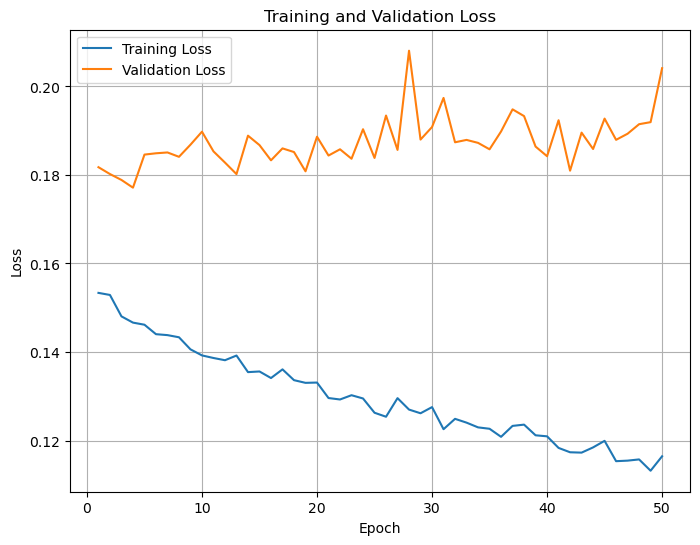

In [17]:
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 평가 및 추론

In [16]:
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_labels, all_preds)
r2 = r2_score(all_labels, all_preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² score: {r2:.4f}")

RMSE: 0.4497
MAE: 0.3594
R² score: 0.1193
